In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [10]:
def load_selected_csvs(base_dir):
    dfs = []
    all_needed_positions = list(set(TRAIN_POSITIONS + TEST_POSITIONS))

    for activity in SELECTED_ACTIVITIES:
        for position in all_needed_positions:
            for csv_path in glob.glob(os.path.join(base_dir, activity, position, "*.csv")):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)

    print(f"Loaded {len(dfs)} recordings.")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])

    if len(X) == 0:
        return np.array([]), np.array([]), np.array([])

    return np.array(X), np.array(y), np.array(groups)

In [11]:
class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        return x + self.pe(pos)

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super().__init__()

        self.embedding = nn.Linear(num_features, 128)
        self.positional_embedding = PositionalEmbedding(WINDOW_SIZE, 128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_embedding(x)
        x = self.encoder(x)
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [12]:
def run_training(X_train, y_train, X_val, y_val, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(MotionDataset(X_train, y_train),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val),
                            batch_size=BATCH_SIZE, shuffle=False)

    model = TransformerClassifier(
        num_features=X_train.shape[2],
        num_classes=num_classes,
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=10
    )

    best_loss = np.inf
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item() * xb.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Val Loss: {val_loss:.4f}")

    model.load_state_dict(best_state)
    return model


def run_cross_position_experiment(all_dfs, feature_cols, title):
    print(title)
    train_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TRAIN_POSITIONS]
    test_dfs  = [df for df in all_dfs if df["phone_position"].iloc[0] in TEST_POSITIONS]

    print(f"Train positions: {TRAIN_POSITIONS} ({len(train_dfs)} recordings)")
    print(f"Test positions:  {TEST_POSITIONS} ({len(test_dfs)} recordings)")

    X_train_full, y_train_full, g_train = build_dataset(train_dfs, feature_cols)
    X_test, y_test, _ = build_dataset(test_dfs, feature_cols)

    le = LabelEncoder()
    le.fit(SELECTED_ACTIVITIES)

    y_train_full = le.transform(y_train_full)
    y_test = le.transform(y_test)

    scaler = StandardScaler()
    N, T, F = X_train_full.shape
    X_train_full = scaler.fit_transform(X_train_full.reshape(-1, F)).reshape(N, T, F)
    X_test = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    tr_idx, va_idx = next(splitter.split(X_train_full, y_train_full, g_train))

    model = run_training(
        X_train_full[tr_idx], y_train_full[tr_idx],
        X_train_full[va_idx], y_train_full[va_idx],
        num_classes=len(le.classes_)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    test_loader = DataLoader(MotionDataset(X_test, y_test),
                             batch_size=BATCH_SIZE, shuffle=False)

    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.numpy())

    print("\nClassification Report")
    print(classification_report(trues, preds, target_names=le.classes_, digits=4))

    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Oranges")
    plt.title(f"{title}\nTrain {TRAIN_POSITIONS} → Test {TEST_POSITIONS}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

Loaded 40 recordings.
Transformer (RAW Features)
Train positions: ['dom_hand'] (20 recordings)
Test positions:  ['nondom_hand'] (20 recordings)
Epoch 10/100 | Val Loss: 0.2009
Epoch 20/100 | Val Loss: 0.2193
Epoch 30/100 | Val Loss: 0.2222
Epoch 40/100 | Val Loss: 0.2259
Epoch 50/100 | Val Loss: 0.2278
Epoch 60/100 | Val Loss: 0.2276
Epoch 70/100 | Val Loss: 0.2283
Epoch 80/100 | Val Loss: 0.2286
Epoch 90/100 | Val Loss: 0.2290
Epoch 100/100 | Val Loss: 0.2291

Classification Report
              precision    recall  f1-score   support

         run     1.0000    0.7280    0.8426       250
         sit     0.3943    1.0000    0.5656       250
      stairs     0.8095    0.0667    0.1232       255
        walk     0.0119    0.0080    0.0096       250

    accuracy                         0.4488      1005
   macro avg     0.5539    0.4507    0.3852      1005
weighted avg     0.5552    0.4488    0.3839      1005



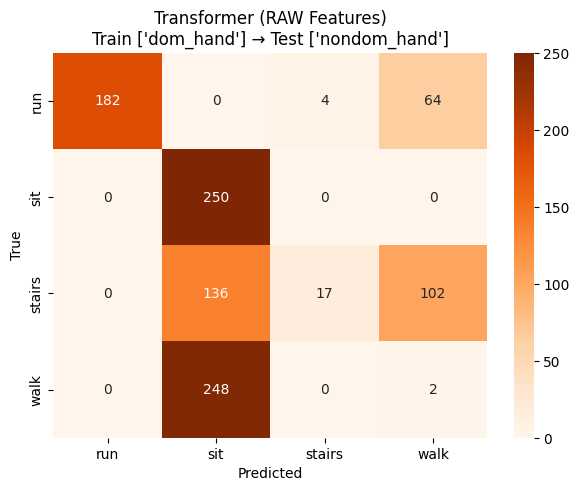

Transformer (GFT Features)
Train positions: ['dom_hand'] (20 recordings)
Test positions:  ['nondom_hand'] (20 recordings)
Epoch 10/100 | Val Loss: 0.2262
Epoch 20/100 | Val Loss: 0.2018
Epoch 30/100 | Val Loss: 0.2312
Epoch 40/100 | Val Loss: 0.2388
Epoch 50/100 | Val Loss: 0.2434
Epoch 60/100 | Val Loss: 0.2465
Epoch 70/100 | Val Loss: 0.2571
Epoch 80/100 | Val Loss: 0.2541
Epoch 90/100 | Val Loss: 0.2520
Epoch 100/100 | Val Loss: 0.2527

Classification Report
              precision    recall  f1-score   support

         run     0.6728    0.8720    0.7596       250
         sit     0.6579    1.0000    0.7937       250
      stairs     0.0000    0.0000    0.0000       255
        walk     0.3591    0.4280    0.3905       250

    accuracy                         0.5721      1005
   macro avg     0.4224    0.5750    0.4859      1005
weighted avg     0.4203    0.5721    0.4835      1005



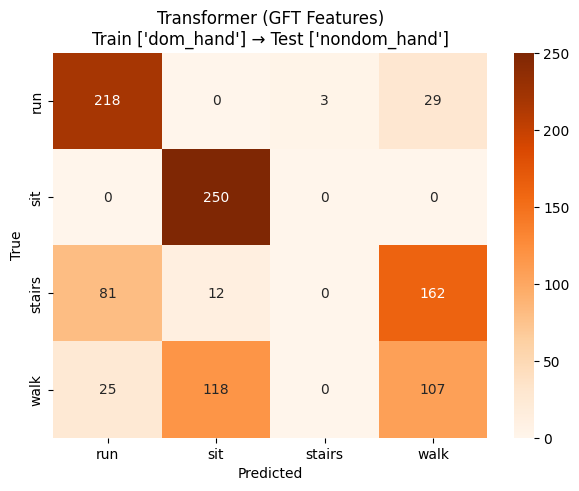

In [13]:
if __name__ == "__main__":
    all_recordings = load_selected_csvs(DATA_DIR)

    run_cross_position_experiment(
        all_recordings, RAW_FEATURES,
        "Transformer (RAW Features)"
    )

    run_cross_position_experiment(
        all_recordings, GFT_FEATURES,
        "Transformer (GFT Features)"
    )